In [51]:
from tsai.all import *
import logging
import matplotlib.pyplot as plt
import zarr
import sklearn.metrics as skm
import seaborn as sns

In [52]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [53]:
#Size of data
valid_size = 0.2
test_size = 0.05
str_size_of_data = 'valid_size_' + str(valid_size) + 'test_size_' + str(test_size)
#dates
file_data = '23_11'
#Problem to solve
problem = "Multiclass"

model_name = "LSTM"
# time resolution
# example 0.001 s -> 0.002 s 
resolution = 0.1

file_for_train_data = 'train_data_' + file_data
file_for_train_data_x = file_for_train_data + '_x'
file_for_train_data_y = file_for_train_data + '_y'
folder_to_save = 'models' + '/' + problem + '/' + model_name + '/' + str_size_of_data + '/'
if model_name in ['LSTM','LSTM_FCN']:
    #model hyperparameters
    hidden_size = 10
    folder_to_save += "hidden_size_" + str(hidden_size)
#learning cycles:
cycles = 4 

In [72]:
class one_model_of_multiple:
    def __init__(self, model_name, X, Y, resolution,
                 valid_size, test_size, hidden_size):
        self.model_name = model_name
        self.Y = Y
        self.X = X
        self.resolution = resolution
        self.valid_size = valid_size
        self.test_size = test_size
        self.hidden_size = hidden_size
        self.stage = 0

        self.encode_one_host()
        self.create_numpy_arrays()
        self.create_zarr_arrays()
        self.create_splits()
        self.create_dlses()

        if self.model_name == "LSTM":
            self.model_tooth = LSTM(self.dls_tooth.vars, self.dls_tooth.c, hidden_size=self.hidden_size, bidirectional=True)
            self.model_shaft = LSTM(self.dls_shaft.vars, self.dls_shaft.c, hidden_size=self.hidden_size, bidirectional=True)
            self.model_drift = LSTM(self.dls_drift.vars, self.dls_drift.c, hidden_size=self.hidden_size, bidirectional=True)
        
        elif self.model_name == "LSTM_FCN":
            self.model_tooth = LSTM_FCN(self.dls_tooth.vars, self.dls_tooth.c, seq_len=self.X_zarr.shape[-1], hidden_size=self.hidden_size, bidirectional=True)
            self.model_shaft = LSTM_FCN(self.dls_shaft.vars, self.dls_shaft.c, seq_len=self.X_zarr.shape[-1], hidden_size=self.hidden_size, bidirectional=True)
            self.model_drift = LSTM_FCN(self.dls_drift.vars, self.dls_drift.c, seq_len=self.X_zarr.shape[-1], hidden_size=self.hidden_size, bidirectional=True)
        
        elif model_name == "FCNPlus":
            self.model_tooth = FCNPlus(self.dls_tooth.vars, self.dls_tooth.c)
            self.model_shaft = FCNPlus(self.dls_shaft.vars, self.dls_shaft.c)
            self.model_drift = FCNPlus(self.dls_drift.vars, self.dls_drift.c)
        
        else:
            raise Exception("Error: Provided bad model name")
        
        logger.info("Initialize learners")
        self.learn_tooth = Learner(self.dls_tooth, self.model_tooth, metrics=accuracy, cbs=ShowGraph())
        self.learn_shaft = Learner(self.dls_shaft, self.model_shaft, metrics=accuracy, cbs=ShowGraph())
        self.learn_drift = Learner(self.dls_drift, self.model_drift, metrics=accuracy, cbs=ShowGraph())
        
        logger.info("Save learner as stage0")
        self.learn_tooth.save('stage' + str(self.stage))
        self.learn_shaft.save('stage' + str(self.stage))
        self.learn_drift.save('stage' + str(self.stage))
        self.stage += 1


        # self.model

    @staticmethod
    def one_hot_encoder(y):
        #[ząb przekładni, wał, dryft]
        return{
            0:[0,0,0],
            1:[0,0,1],
            2:[0,1,0],
            3:[0,1,1],
            4:[1,0,0],
            5:[1,0,1],
            6:[1,1,0],
            7:[1,1,1]
        }[y]

    @staticmethod
    def one_hot_decoder(y):
        #[ząb przekładni, wał, dryft]
        return{
            tuple([0,0,0]):0,
            tuple([0,0,1]):1,
            tuple([0,1,0]):2,
            tuple([0,1,1]):3,
            tuple([1,0,0]):4,
            tuple([1,0,1]):5,
            tuple([1,1,0]):6,
            tuple([1,1,1]):7
        }[y]

    def encode_one_host(self):
        self.Y_fault_tooth = []
        self.Y_fault_shaft = []
        self.Y_fault_drift = []
        for y in self.Y:
            (tooth, shaft, drift) = self.one_hot_encoder(y)
            self.Y_fault_tooth.append(tooth)
            self.Y_fault_shaft.append(shaft)
            self.Y_fault_drift.append(drift)


    def create_numpy_arrays(self):
        logger.info("Create numpy array with X and Y")
        self.X_numpy = np.array(self.X)    

        self.Y_numpy_tooth = np.array(self.Y_fault_tooth)
        self.Y_numpy_shaft = np.array(self.Y_fault_shaft)
        self.Y_numpy_drift = np.array(self.Y_fault_drift)

        # logger.info("Sample X for every 100 samples")
        # to take with resolution defined before:
        samples_to_take = self.resolution * 1000
        self.X_numpy = self.X_numpy[:, :, :: int(samples_to_take)]

    def create_zarr_arrays(self):
        logger.info("Create zarr array's with X and Y")
        path = Path('data')
        if not os.path.exists(path): os.makedirs(path)
        
        self.X_zarr = zarr.open(path/'X_zarr.zarr', mode='w', shape=self.X_numpy.shape, dtype=self.X_numpy.dtype, chunks=(1, -1, -1))
        self.X_zarr[:] = self.X_numpy

        self.X_zarr = zarr.open(path/'X_zarr.zarr', mode='r')
        self.Y_zarr_tooth = zarr.open(path/'y_zarr_tooth.zarr', mode='w', shape=self.Y_numpy_tooth.shape, dtype=self.Y_numpy_tooth.dtype, chunks=False) # y data is small and don't need to be chunked
        self.Y_zarr_shaft = zarr.open(path/'y_zarr_shaft.zarr', mode='w', shape=self.Y_numpy_shaft.shape, dtype=self.Y_numpy_shaft.dtype, chunks=False) # y data is small and don't need to be chunked
        self.Y_zarr_drift = zarr.open(path/'y_zarr_drift.zarr', mode='w', shape=self.Y_numpy_drift.shape, dtype=self.Y_numpy_drift.dtype, chunks=False) # y data is small and don't need to be chunked
        
        self.Y_zarr_tooth[:] = self.Y_numpy_tooth
        self.Y_zarr_shaft[:] = self.Y_numpy_shaft
        self.Y_zarr_drift[:] = self.Y_numpy_drift

    def create_splits(self):
        logger.info("Create splits")
        train_only = False  # set to True for debugging (valid = train)
        stratify = True
        balance = False
        shuffle = True
        predefined_splits = None
        show_plot = False 


        check_splits = True
        random_state = 23
        logger.info("Split data to train and valid")
        #Set show plot to True if you want to see split, but this stops main thread
        self.splits = get_splits(self.X_zarr, valid_size=self.valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                            train_only=train_only, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)


    def create_dlses(self):
        logger.info("Create dlses")
        tfms  = [None, TSClassification()] # TSClassification == Categorize
        batch_tfms = TSStandardize(by_var=True)
        self.dls_tooth = get_ts_dls(self.X_zarr, self.Y_zarr_tooth, splits=self.splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=8, num_workers=12) 
        self.dls_shaft = get_ts_dls(self.X_zarr, self.Y_zarr_shaft, splits=self.splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=8, num_workers=12) 
        self.dls_drift = get_ts_dls(self.X_zarr, self.Y_zarr_drift, splits=self.splits, tfms=tfms, batch_tfms=batch_tfms, inplace=False, bs=8, num_workers=12) 
        # num_workers = 1 *cpus

    def fit_one_cycle(self, cycle=2):
        logger.info("Initialize learners")
        self.learn_tooth.fit_one_cycle(cycle, lr_max=1e-3)
        self.learn_shaft.fit_one_cycle(cycle, lr_max=1e-3)
        self.learn_drift.fit_one_cycle(cycle, lr_max=1e-3)

        logger.info("Save learners as stage1")
        self.learn_tooth.save('stage' + str(self.stage))
        self.learn_shaft.save('stage' + str(self.stage))
        self.learn_drift.save('stage' + str(self.stage))
        self.stage += 1

        self.learn_tooth.recorder.plot_metrics()
        self.learn_shaft.recorder.plot_metrics()
        self.learn_drift.recorder.plot_metrics()
    
    def plot_confusion_matrixes_for_valid(self):
        self.interp_tooth = ClassificationInterpretation.from_learner(self.learn_tooth)
        self.interp_shaft = ClassificationInterpretation.from_learner(self.learn_shaft)
        self.interp_drift = ClassificationInterpretation.from_learner(self.learn_drift)
        
        self.interp_tooth.plot_confusion_matrix(title="Confusion matrix tooth")
        self.interp_shaft.plot_confusion_matrix(title="Confusion matrix shaft")
        self.interp_drift.plot_confusion_matrix(title="Confusion matrix drift")

    def save_all(self, folder_to_save):
        self.learn_tooth.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner_tooth')
        self.learn_shaft.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner_shaft')
        self.learn_drift.save_all(path=folder_to_save, dls_fname='dls', model_fname='model', learner_fname='learner_drift')
    
    def get_preds(self):
        model_predictions = torch.tensor([])
        model_targets = torch.tensor([])

        _, self.val_target_tooth, self.val_preds_tooth = self.learn_tooth.get_preds(with_decoded = True)
        _, self.val_target_shaft, self.val_preds_shaft = self.learn_shaft.get_preds(with_decoded = True)
        _, self.val_target_drift, self.val_preds_drift = self.learn_drift.get_preds(with_decoded = True)
        for idx_pred in range(len(self.val_preds_tooth)):
            one_hot_model_pred = [self.val_preds_tooth[idx_pred].item(), self.val_preds_shaft[idx_pred].item(), self.val_preds_drift[idx_pred].item()]
            
            one_hot_model_target = [self.val_target_tooth[idx_pred].item(), self.val_target_shaft[idx_pred].item(), self.val_target_drift[idx_pred].item()]
            decode_prediction = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_pred))])
            model_predictions = torch.cat((model_predictions, decode_prediction), dim=-1)
            
            decode_target = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_target))])
            model_targets = torch.cat((model_targets, decode_target), dim=-1)
        return model_targets, model_predictions

    def take_test(self):
        self.X_test , self.Y_test_tooth = np.take(self.X_zarr, self.splits[2], axis=0), np.take(self.Y_zarr_tooth, self.splits[2], axis=0)
        self.Y_test_shaft , self.Y_test_drift = np.take(self.Y_zarr_shaft, self.splits[2], axis=0), np.take(self.Y_zarr_drift, self.splits[2], axis=0)

    def create_test(self):
        self.take_test()

        self.valid_dl_tooth = self.learn_tooth.dls.valid
        self.valid_dl_shaft = self.learn_shaft.dls.valid
        self.valid_dl_drift = self.learn_drift.dls.valid
        
        self.test_ds_tooth = self.valid_dl_tooth.dataset.add_test(self.X_test, self.Y_test_tooth)
        self.test_ds_shaft = self.valid_dl_shaft.dataset.add_test(self.X_test, self.Y_test_shaft)
        self.test_ds_drift = self.valid_dl_drift.dataset.add_test(self.X_test, self.Y_test_drift)

        self.test_dl_tooth = self.valid_dl_tooth.new(self.test_ds_tooth)
        self.test_dl_shaft = self.valid_dl_shaft.new(self.test_ds_shaft)
        self.test_dl_drift = self.valid_dl_drift.new(self.test_ds_drift)

        next(iter(self.test_dl_tooth))
        next(iter(self.test_dl_shaft))
        next(iter(self.test_dl_drift))
    
    def get_preds_test(self):
        self.create_test()

        model_predictions = torch.tensor([])
        model_targets = torch.tensor([])

        _, self.test_target_tooth, self.test_preds_tooth = self.learn_tooth.get_preds(dl=self.test_dl_tooth, with_decoded=True, save_preds=None, save_targs=None)
        _, self.test_target_shaft, self.test_preds_shaft = self.learn_shaft.get_preds(dl=self.test_dl_shaft, with_decoded=True, save_preds=None, save_targs=None)
        _, self.test_target_drift, self.test_preds_drift = self.learn_drift.get_preds(dl=self.test_dl_drift, with_decoded=True, save_preds=None, save_targs=None)

        for idx_pred in range(len(self.test_preds_tooth)):
            one_hot_model_pred = [self.test_preds_tooth[idx_pred].item(), self.test_preds_shaft[idx_pred].item(), self.test_preds_drift[idx_pred].item()]
            one_hot_model_target = [self.test_target_tooth[idx_pred].item(), self.test_target_shaft[idx_pred].item(), self.test_target_drift[idx_pred].item()]
            
            decode_prediction = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_pred))])
            model_predictions = torch.cat((model_predictions, decode_prediction), dim=-1)
            decode_target = torch.tensor([self.one_hot_decoder(tuple(one_hot_model_target))])
            model_targets = torch.cat((model_targets, decode_target), dim=-1)

        return model_targets, model_predictions



        

        


    # model = LSTM(dls.vars, dls.c, hidden_size=hidden_size, bidirectional=True)

In [55]:
def list_from_file(filename):
    with open(filename, "rb") as fp:
        return pickle.load(fp)

In [56]:
logger.info(f"Get train data from files: {file_for_train_data_x}, {file_for_train_data_y}")
X = list_from_file(file_for_train_data_x)
Y = list_from_file(file_for_train_data_y)

INFO:__main__:Get train data from files: train_data_23_11_x, train_data_23_11_y


INFO:__main__:Create numpy array with X and Y
INFO:__main__:Create zarr array's with X and Y
INFO:__main__:Create splits
INFO:__main__:Split data to train and valid
INFO:__main__:Create dlses
INFO:__main__:Initialize learners
INFO:__main__:Save learner as stage0
INFO:__main__:Initialize learners


stratify set to False as the least populated class in o has only 1 member, which is too few.


epoch,train_loss,valid_loss,accuracy,time
0,0.695574,0.695266,0.500000,00:03
1,0.694595,0.696167,0.488095,00:03


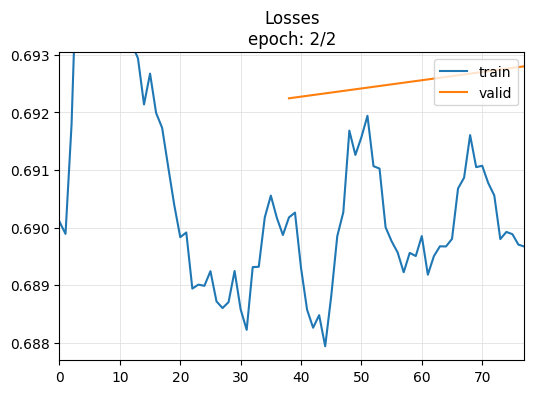

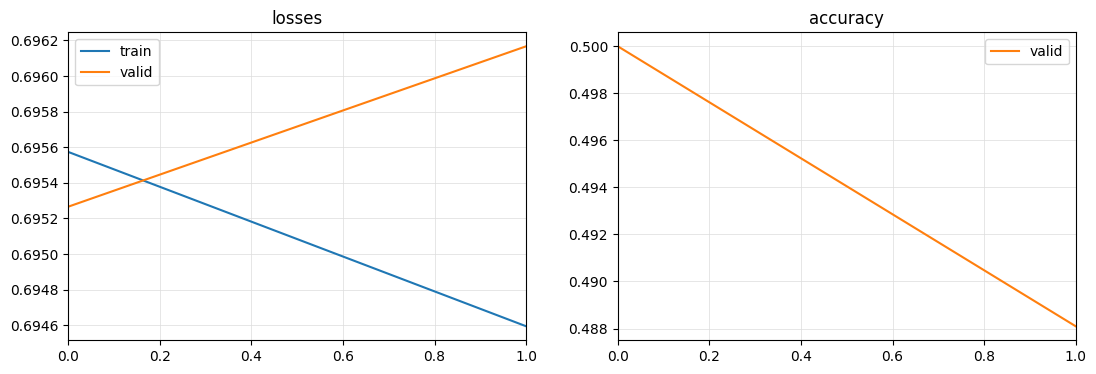

epoch,train_loss,valid_loss,accuracy,time
0,0.712578,0.692464,0.571429,00:03
1,0.706414,0.691569,0.559524,00:03


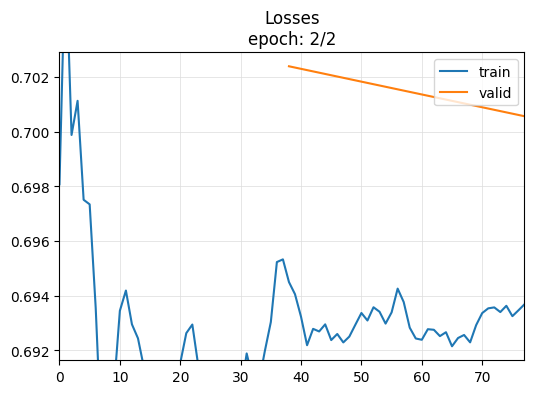

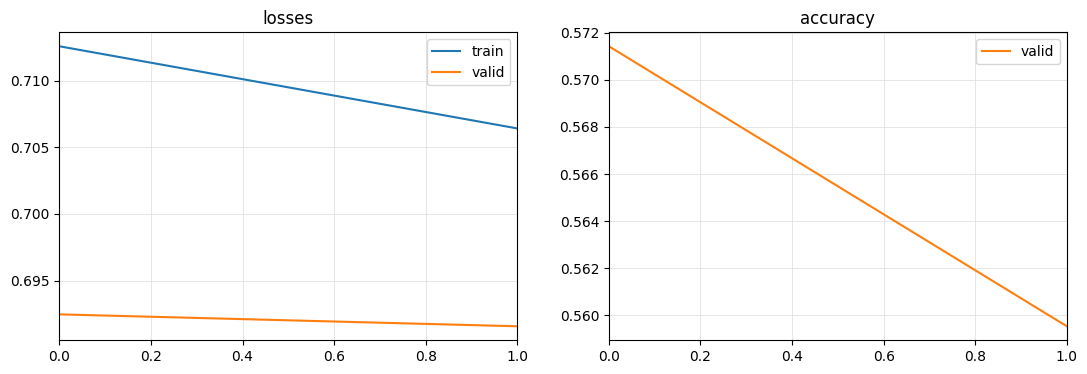

epoch,train_loss,valid_loss,accuracy,time
0,0.687011,0.676714,0.678571,00:03
1,0.681858,0.671681,0.678571,00:03


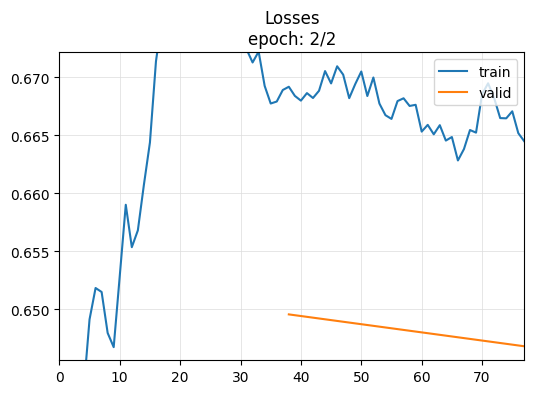

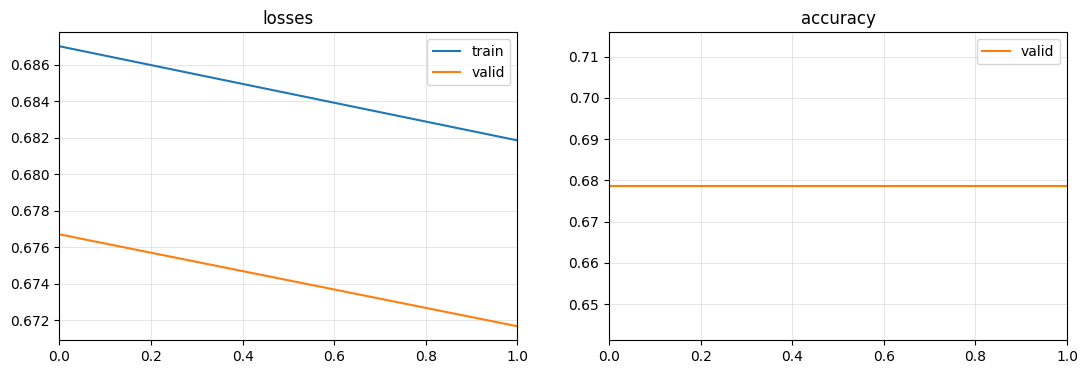

INFO:__main__:Save learners as stage1


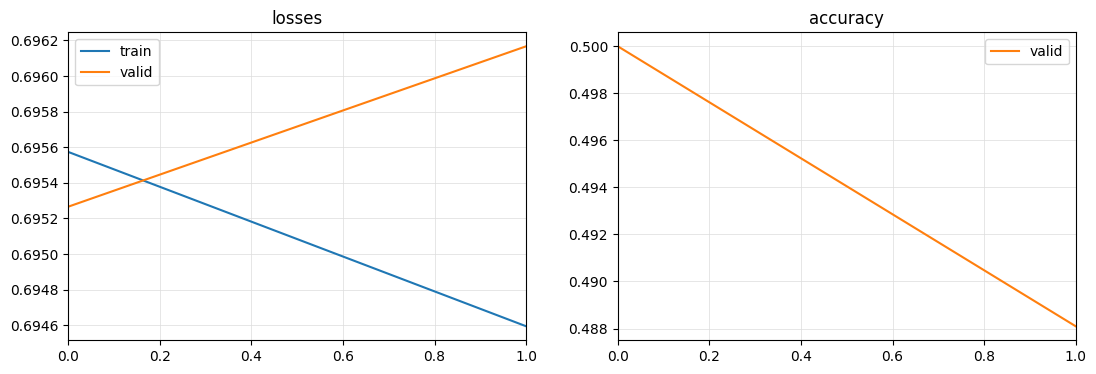

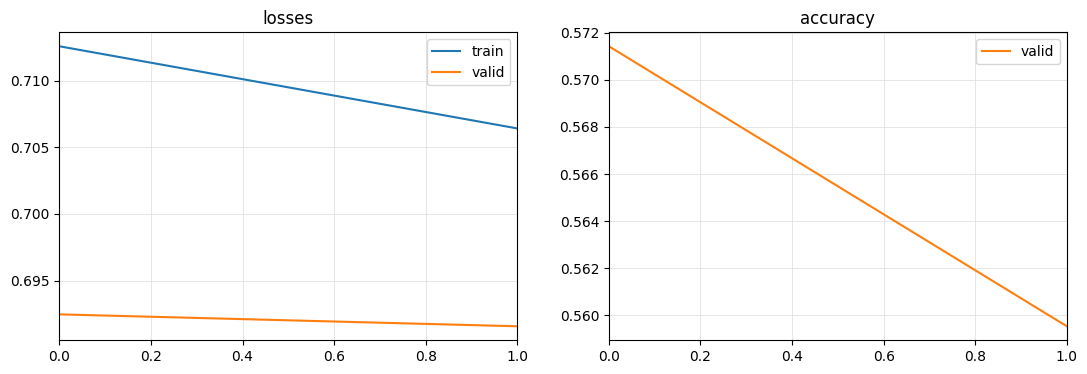

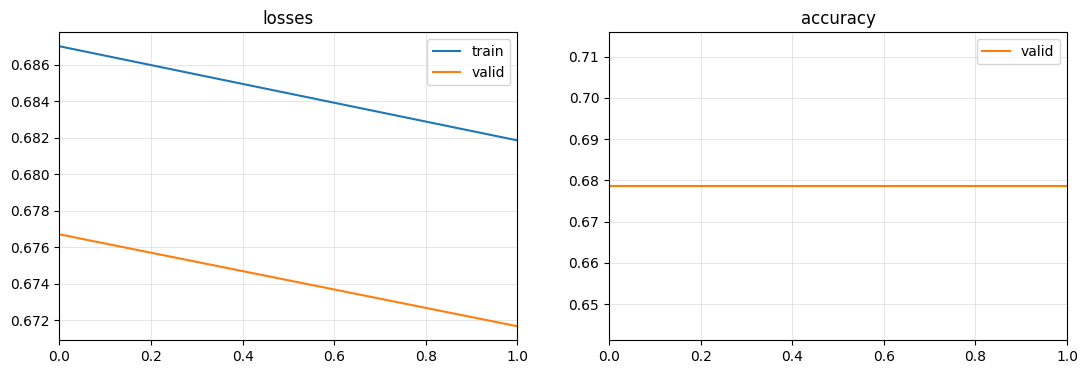

onehott5
tensor([5.])
tensor([4.])
onehott5
tensor([5., 5.])
tensor([4., 3.])
onehott4
tensor([5., 5., 4.])
tensor([4., 3., 4.])
onehott4
tensor([5., 5., 4., 4.])
tensor([4., 3., 4., 2.])
onehott2
tensor([5., 5., 4., 4., 2.])
tensor([4., 3., 4., 2., 5.])
onehott4
tensor([5., 5., 4., 4., 2., 4.])
tensor([4., 3., 4., 2., 5., 4.])
onehott5
tensor([5., 5., 4., 4., 2., 4., 5.])
tensor([4., 3., 4., 2., 5., 4., 2.])
onehott5
tensor([5., 5., 4., 4., 2., 4., 5., 5.])
tensor([4., 3., 4., 2., 5., 4., 2., 0.])
onehott4
tensor([5., 5., 4., 4., 2., 4., 5., 5., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2.])
onehott5
tensor([5., 5., 4., 4., 2., 4., 5., 5., 4., 5.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2.])
onehott1
tensor([5., 5., 4., 4., 2., 4., 5., 5., 4., 5., 1.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1.])
onehott4
tensor([5., 5., 4., 4., 2., 4., 5., 5., 4., 5., 1., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1., 2.])
onehott5
tensor([5., 5., 4., 4., 2., 4., 5., 5., 4.,

INFO:__main__:Initialize learners


epoch,train_loss,valid_loss,accuracy,time
0,0.691873,0.692056,0.547619,00:03
1,0.691107,0.692913,0.535714,00:03


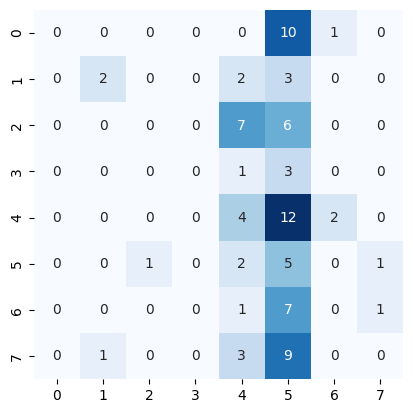

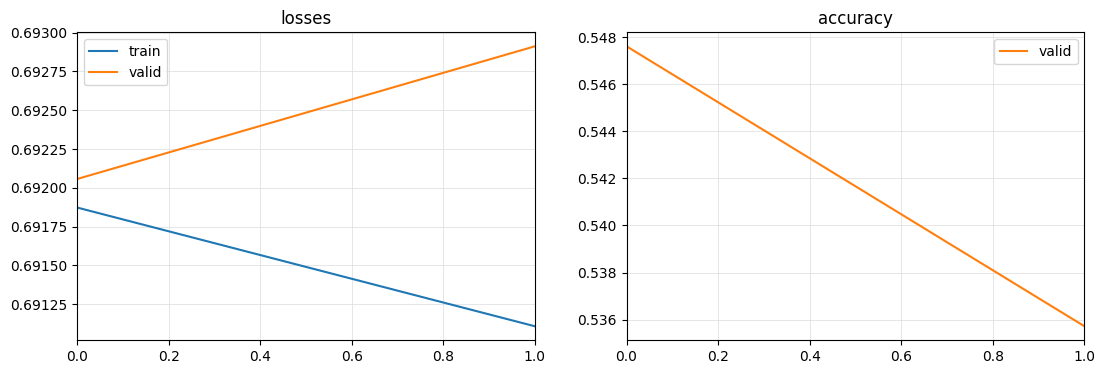

epoch,train_loss,valid_loss,accuracy,time
0,0.698971,0.696287,0.500000,00:03
1,0.696015,0.698123,0.428571,00:03


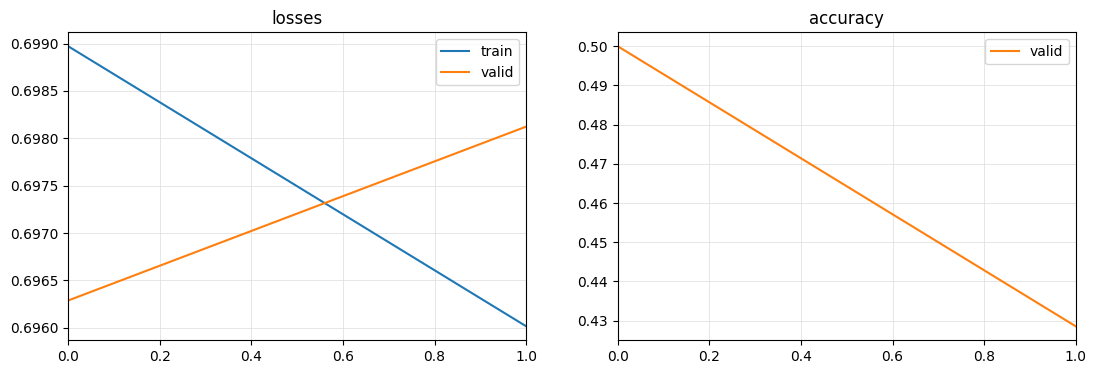

epoch,train_loss,valid_loss,accuracy,time
0,0.679444,0.667639,0.642857,00:03
1,0.678912,0.661634,0.642857,00:03


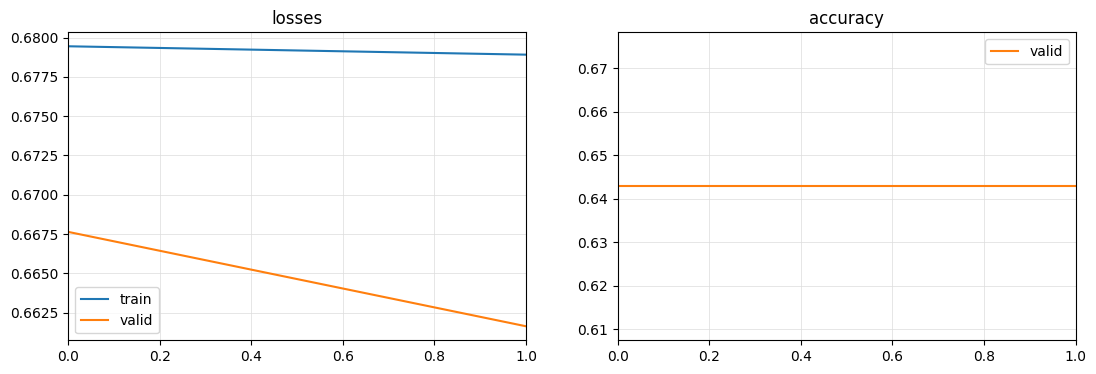

INFO:__main__:Save learners as stage1


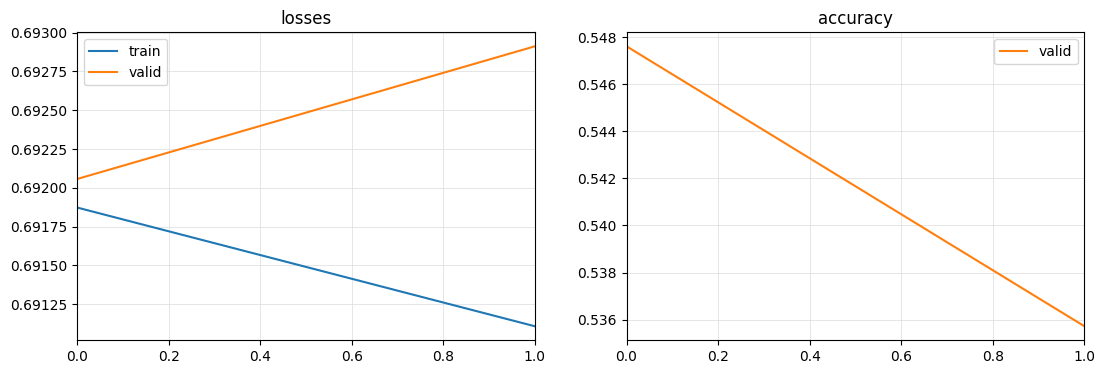

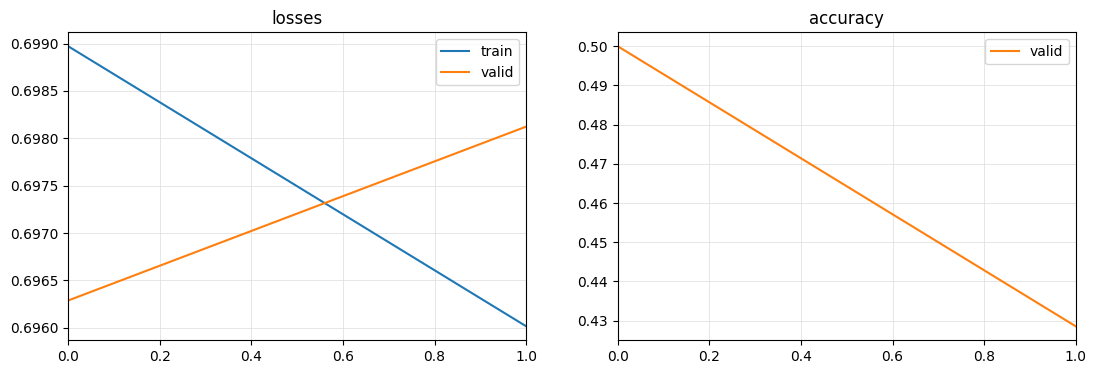

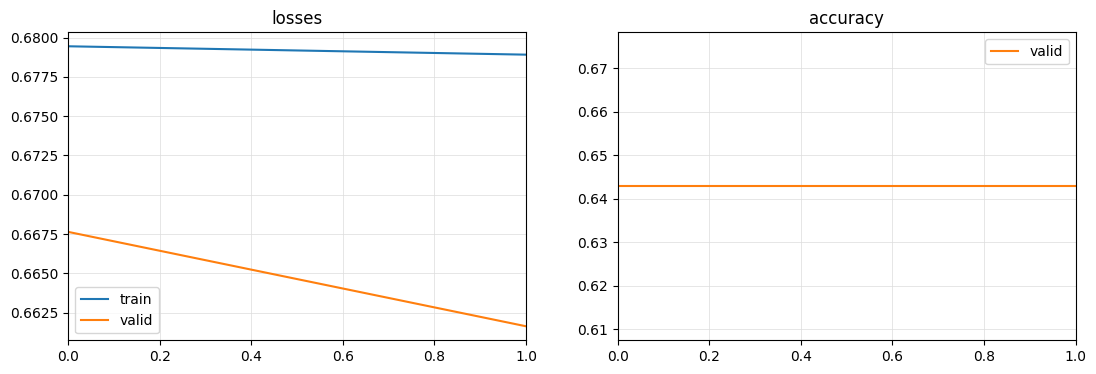

onehott0
tensor([0.])
tensor([4.])
onehott4
tensor([0., 4.])
tensor([4., 3.])
onehott4
tensor([0., 4., 4.])
tensor([4., 3., 4.])
onehott6
tensor([0., 4., 4., 6.])
tensor([4., 3., 4., 2.])
onehott2
tensor([0., 4., 4., 6., 2.])
tensor([4., 3., 4., 2., 5.])
onehott4
tensor([0., 4., 4., 6., 2., 4.])
tensor([4., 3., 4., 2., 5., 4.])
onehott4
tensor([0., 4., 4., 6., 2., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2.])
onehott4
tensor([0., 4., 4., 6., 2., 4., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0.])
onehott4
tensor([0., 4., 4., 6., 2., 4., 4., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2.])
onehott4
tensor([0., 4., 4., 6., 2., 4., 4., 4., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2.])
onehott1
tensor([0., 4., 4., 6., 2., 4., 4., 4., 4., 4., 1.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1.])
onehott4
tensor([0., 4., 4., 6., 2., 4., 4., 4., 4., 4., 1., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1., 2.])
onehott6
tensor([0., 4., 4., 6., 2., 4., 4., 4., 4.,

INFO:__main__:Initialize learners


epoch,train_loss,valid_loss,accuracy,time
0,0.690923,0.693416,0.523810,00:03
1,0.691312,0.691955,0.547619,00:03


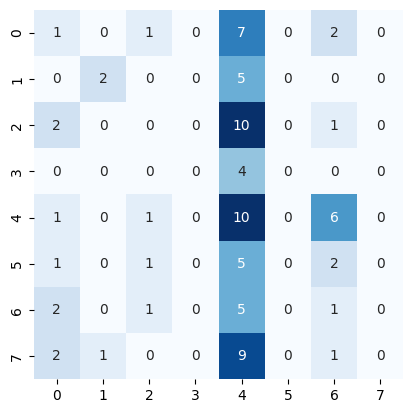

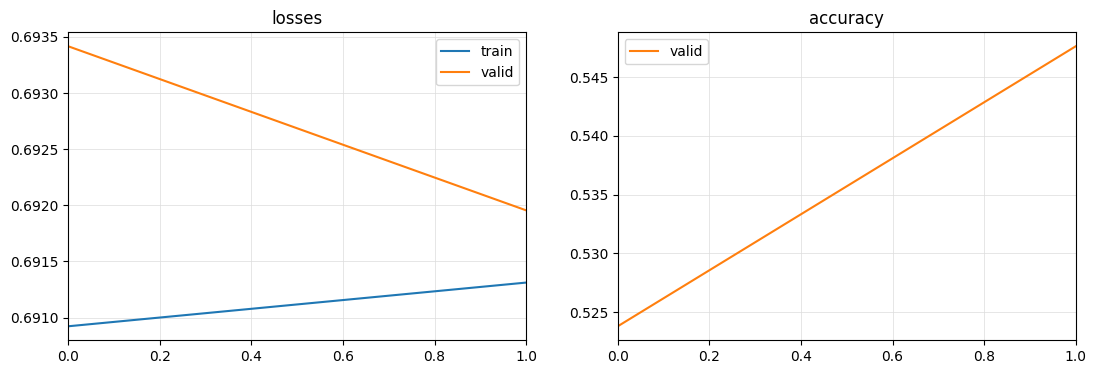

epoch,train_loss,valid_loss,accuracy,time
0,0.694410,0.700602,0.428571,00:03
1,0.693401,0.701881,0.404762,00:03


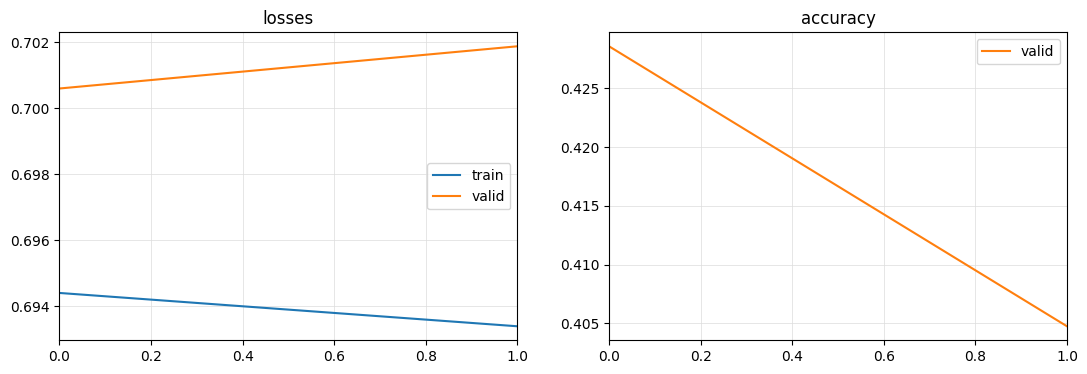

epoch,train_loss,valid_loss,accuracy,time
0,0.672142,0.659263,0.666667,00:03
1,0.670708,0.656590,0.690476,00:03


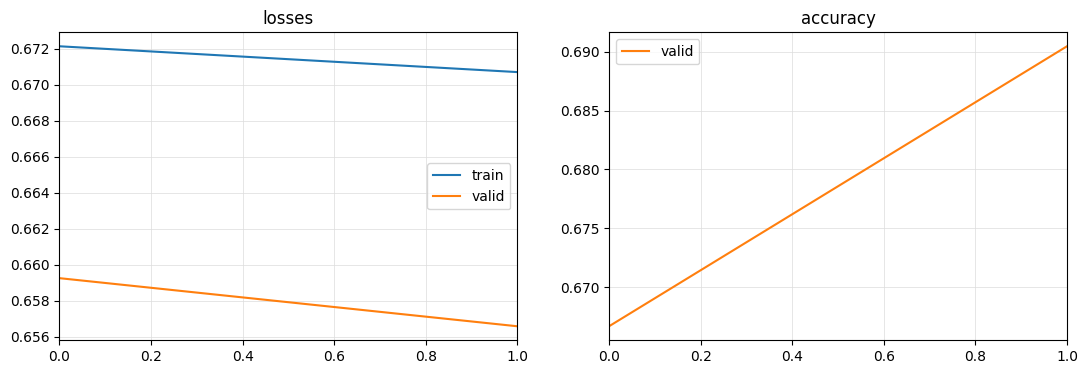

INFO:__main__:Save learners as stage1


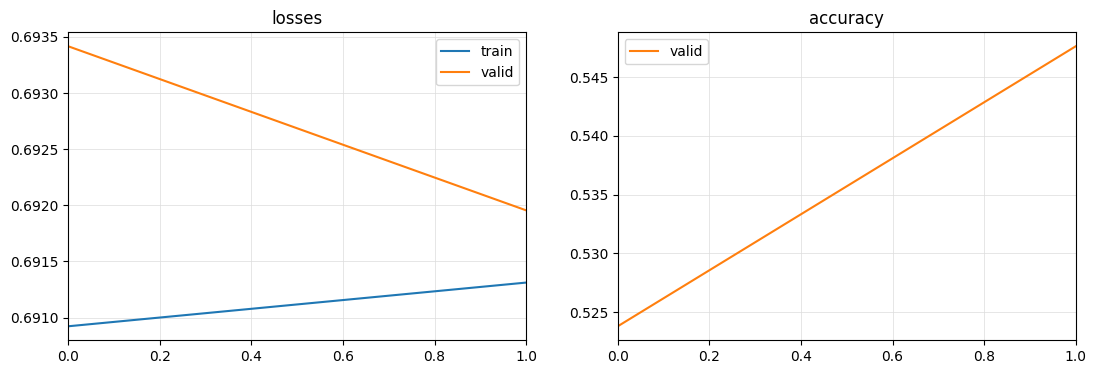

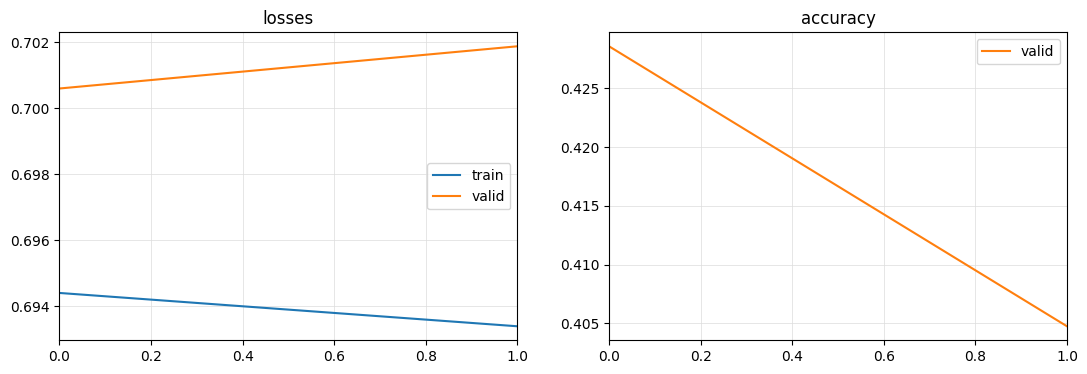

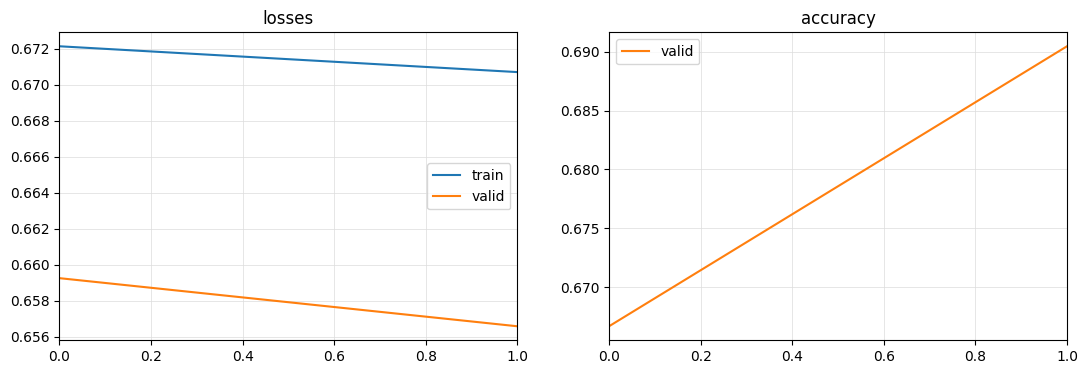

onehott6
tensor([6.])
tensor([4.])
onehott4
tensor([6., 4.])
tensor([4., 3.])
onehott6
tensor([6., 4., 6.])
tensor([4., 3., 4.])
onehott6
tensor([6., 4., 6., 6.])
tensor([4., 3., 4., 2.])
onehott2
tensor([6., 4., 6., 6., 2.])
tensor([4., 3., 4., 2., 5.])
onehott4
tensor([6., 4., 6., 6., 2., 4.])
tensor([4., 3., 4., 2., 5., 4.])
onehott4
tensor([6., 4., 6., 6., 2., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2.])
onehott6
tensor([6., 4., 6., 6., 2., 4., 4., 6.])
tensor([4., 3., 4., 2., 5., 4., 2., 0.])
onehott4
tensor([6., 4., 6., 6., 2., 4., 4., 6., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2.])
onehott4
tensor([6., 4., 6., 6., 2., 4., 4., 6., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2.])
onehott1
tensor([6., 4., 6., 6., 2., 4., 4., 6., 4., 4., 1.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1.])
onehott4
tensor([6., 4., 6., 6., 2., 4., 4., 6., 4., 4., 1., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1., 2.])
onehott6
tensor([6., 4., 6., 6., 2., 4., 4., 6., 4.,

INFO:__main__:Initialize learners


epoch,train_loss,valid_loss,accuracy,time
0,0.690175,0.692244,0.523810,00:03
1,0.689669,0.692801,0.523810,00:03


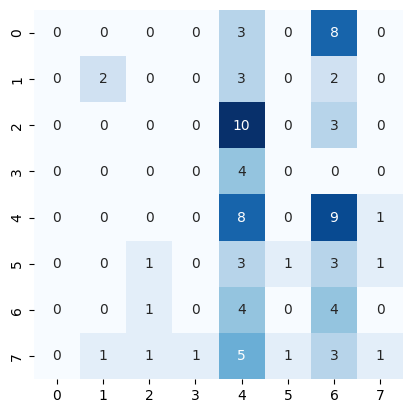

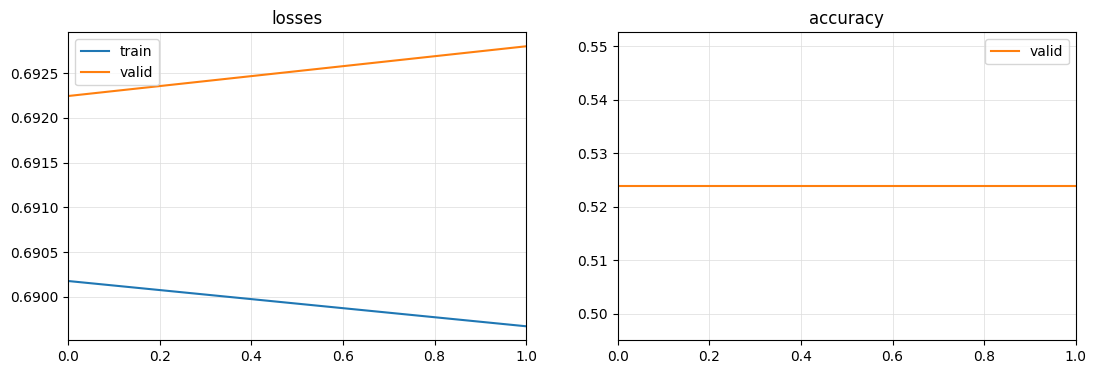

epoch,train_loss,valid_loss,accuracy,time
0,0.694498,0.702393,0.440476,00:03
1,0.693684,0.700566,0.404762,00:03


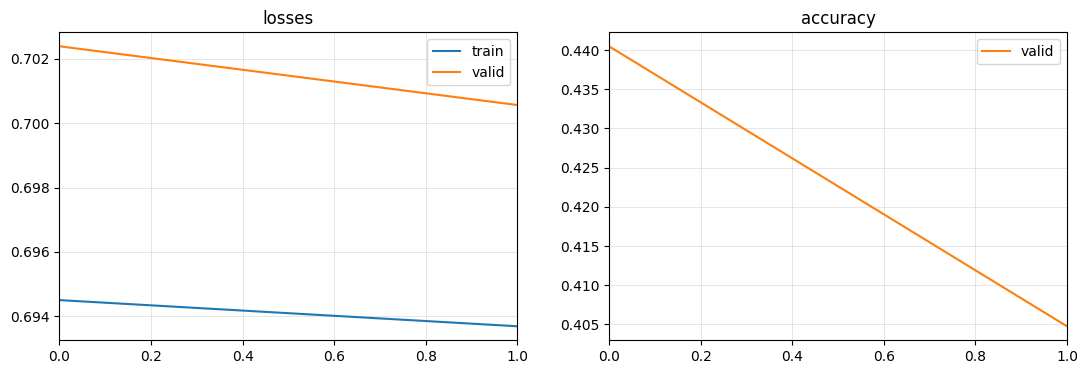

epoch,train_loss,valid_loss,accuracy,time
0,0.669188,0.649552,0.678571,00:03
1,0.664477,0.646801,0.690476,00:03


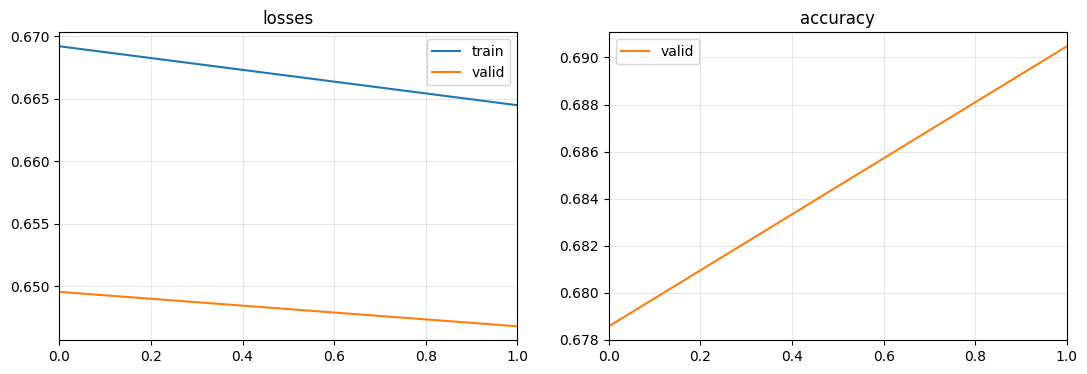

INFO:__main__:Save learners as stage1


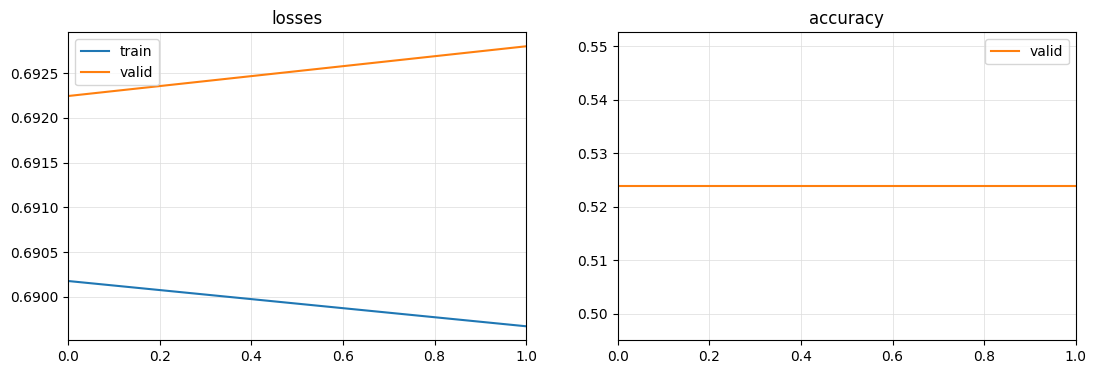

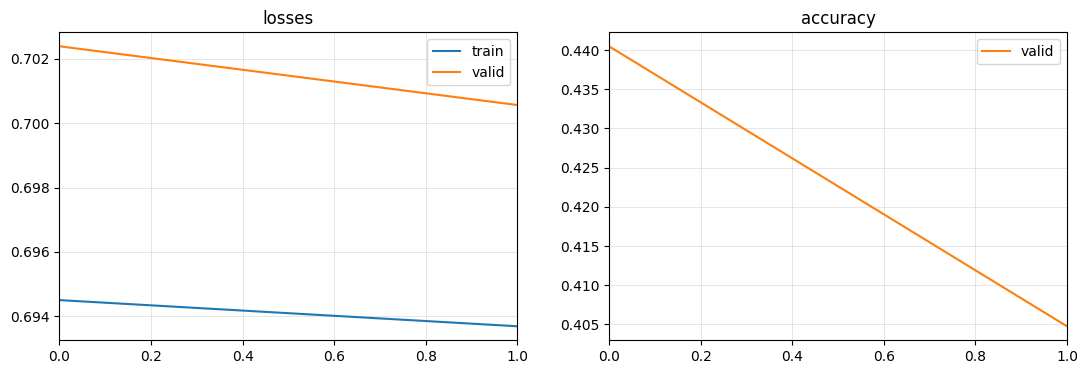

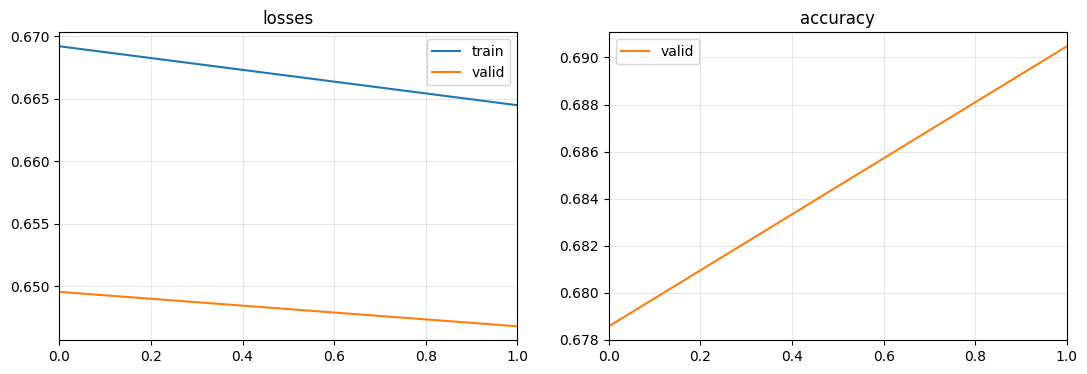

onehott6
tensor([6.])
tensor([4.])
onehott4
tensor([6., 4.])
tensor([4., 3.])
onehott6
tensor([6., 4., 6.])
tensor([4., 3., 4.])
onehott2
tensor([6., 4., 6., 2.])
tensor([4., 3., 4., 2.])
onehott2
tensor([6., 4., 6., 2., 2.])
tensor([4., 3., 4., 2., 5.])
onehott4
tensor([6., 4., 6., 2., 2., 4.])
tensor([4., 3., 4., 2., 5., 4.])
onehott4
tensor([6., 4., 6., 2., 2., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2.])
onehott6
tensor([6., 4., 6., 2., 2., 4., 4., 6.])
tensor([4., 3., 4., 2., 5., 4., 2., 0.])
onehott4
tensor([6., 4., 6., 2., 2., 4., 4., 6., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2.])
onehott4
tensor([6., 4., 6., 2., 2., 4., 4., 6., 4., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2.])
onehott5
tensor([6., 4., 6., 2., 2., 4., 4., 6., 4., 4., 5.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1.])
onehott4
tensor([6., 4., 6., 2., 2., 4., 4., 6., 4., 4., 5., 4.])
tensor([4., 3., 4., 2., 5., 4., 2., 0., 2., 2., 1., 2.])
onehott6
tensor([6., 4., 6., 2., 2., 4., 4., 6., 4.,

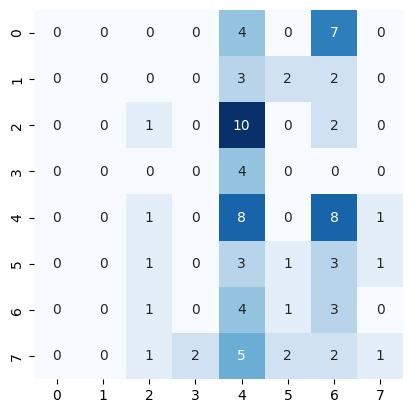

In [73]:
model = one_model_of_multiple(model_name, X, Y, resolution, 
                                valid_size, test_size, hidden_size)
for _ in range(cycles):
    model.fit_one_cycle()
    model.save_all(folder_to_save)
    val_targets, val_preds = model.get_preds()
    print(val_targets)
    print(val_preds)
    conf_mat = skm.confusion_matrix(val_targets, val_preds)
    sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [ ]:
test_targets, test_preds = model.get_test_preds()

In [ ]:
logger.info(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
logger.info(f'recall: {skm.recall_score(test_targets, test_preds, average="macro"):10.6f}')
#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn 
#the number of false negatives. The recall is intuitively the ability of the classifier to find
#all the positive samples.
logger.info(f'precision: {skm.precision_score(test_targets, test_preds, average="macro"):10.6f}')
#The precision is the ratio tp / (tp + fp) where 
#tp is the number of true positives and fp the number
#of false positives. The precision is intuitively the
#ability of the classifier not to label as positive a sample that is negative.
logger.info(f'jaccard: {skm.jaccard_score(test_targets, test_preds, average="macro"):10.6f}')
#The Jaccard index [1], or Jaccard similarity coefficient, 
#defined as the size of the intersection divided by the size 
#of the union of two label sets, is used to compare set of predicted
#labels for a sample to the corresponding set of labels in y_true.

#Add others metrics

In [ ]:
conf_mat = skm.confusion_matrix(test_targets, test_preds)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)